In [1]:
# Author: Anne Sabourin
# Description: Principal Compoennt Analysis of multivariate extremes
# Date: May 2025

# Tutorial notebook for Principal Component Analysis of multivariate extremes, `unsupervised.pca` sub-package

Implements and illustrates the methodology and theory developed in

    * Drees, H., & Sabourin, A. (2021). Principal component analysis for multivariate extremes

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import MLExtreme as mlx

In [3]:
# RV-dirimix  data generation p = 2
n = 10000  # Number of samples
p = 3  # Ambient dimension (2D in this case)
k = 2  # Number of components in the Dirichlet mixture
alpha = 6 # Shape parameter of the Pareto distribution

# Mixture means (Mu), log scale (lnu), and weights (wei)
Mu = np.array([[0.1, 0.1, 0.8], [0.45, 0.45, 0.1]])  # k* p matrix of means
lnu = np.log([50, 50])  # log(10) for both components
wei = np.array([0.5, 0.5])  # weights for the mixture components
Mu, wei = mlx.normalize_param_dirimix(Mu, wei)
# # inspect the angular density
# Mu_wei = wei  @ Mu
# # Display the result
# print(Mu_wei)
# mlx.plot_pdf_dirimix_3D(Mu, wei, lnu)
np.random.seed(1)
X = mlx.gen_rv_dirimix(alpha, Mu, wei, lnu, scale_weight_noise=1,
                       index_weight_noise=alpha*1.1,
                       size=n)

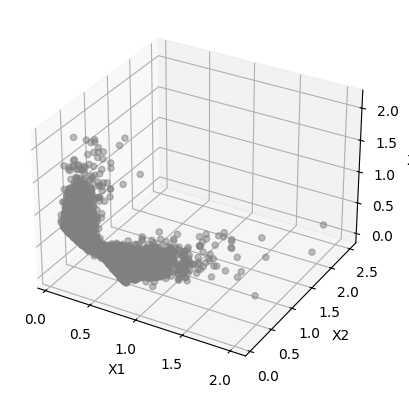

In [4]:
# Data Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color='gray', alpha=0.5)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.show()

## Data analysis

In [5]:
# Select the radial threshold via distance-covariance tests.
# See the tutorials on classification and regression for more details.
def norm_func(x):
    return np.sum(x**2, axis=1)**(1/2)


ntests_thresh = 10
ratio_ext = np.geomspace(0.05, 0.8, num=ntests_thresh)
pval, ratio_max = mlx.test_indep_radius_rest(X, y=None, ratio_ext=ratio_ext,
                                             norm_func=norm_func)

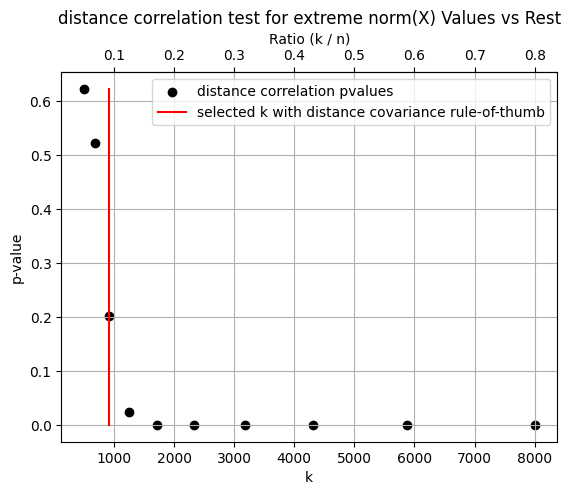

In [6]:
mlx.plot_indep_radius_rest(pval, ratio_ext, ratio_max, n)

In [7]:
# threshold selection
norm_X = norm_func(X)
thresh_train = np.quantile(norm_X, q=1-ratio_max/1.2)

In [8]:
# Model fitting
xpca = mlx.Xpca(thresh_train=thresh_train, beta=1, centered=True)
xpca.fit(X)

[239.53435706   9.0520492    0.98307207]
[[-0.45460566  0.70264316  0.54738129]
 [-0.44517466 -0.71153399  0.5436349 ]
 [ 0.77146174  0.00345922  0.63626631]]


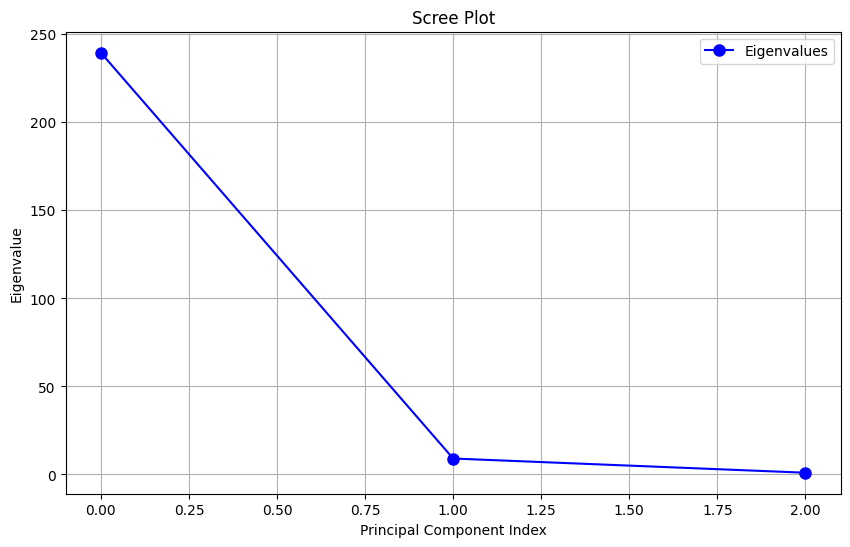

In [9]:
# quick exploration of the output
print(xpca.eigenvalues)
print(xpca.principal_axes)
xpca.screeplot()

In [10]:
# usage on a test set: PCA scores and reconstruction
X_test = mlx.gen_rv_dirimix(alpha, Mu, wei, lnu, scale_weight_noise=1,
                            index_weight_noise=3,
                            size=n)

X_test_recons, X_test_extreme, mask = xpca.predict(X_test, max_dim=1)

In [11]:
# check whether some recontructed entries are negative (undesirable in spirit, unlikely, but possible)
np.min(X_test_recons)

np.float64(0.04765163527806869)

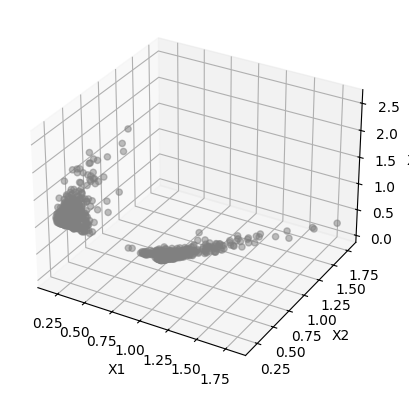

In [12]:
# visualization
fig = plt.figure()
Z = X_test_recons
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], color='gray', alpha=0.5)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.show()

In [13]:
Scores, _, _ = xpca.scores(X_test, max_dim=3)

print(Scores)
print(xpca.mean_angle)

[[-0.47060294 -0.16096419  0.057135  ]
 [-0.58387531  0.02909017  0.00477891]
 [ 0.49413061  0.00585376  0.03381262]
 ...
 [ 0.49567856 -0.16012312  0.01781725]
 [-0.23768704 -0.10519651  0.14861213]
 [-0.64251444 -0.00799737 -0.03770147]]
[0.44001373 0.43682768 0.54064126]


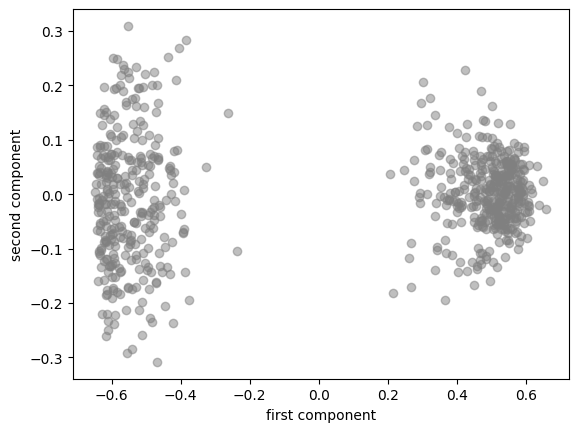

In [14]:
# Scores visualzation
plt.figure()
plt.scatter(Scores[:, 0], Scores[:, 1], c='gray', alpha=0.5)
plt.xlabel('first component')
plt.ylabel('second component')
plt.show()

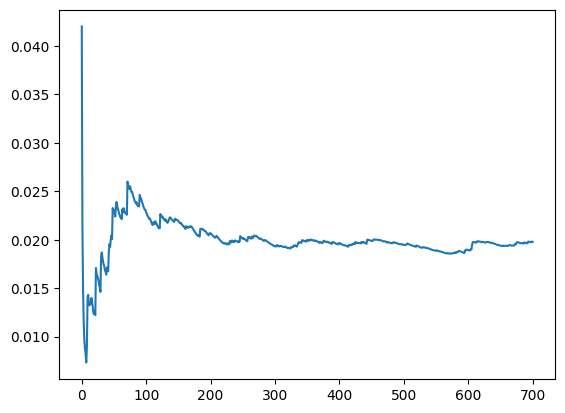

In [15]:
# Mean reconstruction error
Err = xpca.recons_error(X_test, max_dim=1, test_beta=0)
n_ext = len(Err)
cumMSE = np.cumsum(Err)/np.arange(1, n_ext+1)
plt.figure()
plt.plot(cumMSE)
plt.show()